<a href="https://colab.research.google.com/github/shubhamscifi/Instacart-Market-Basket-Analysis/blob/main/8.%20More%20Predictive%20Models(ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Instacart Market Basket Analysis](https://www.kaggle.com/c/instacart-market-basket-analysis/)**

---
- Given order_id predict all the products that the user will reorder.

---








## Importing libraries

In [ ]:
import plotly
import plotly.express as px
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import gc   # garbage collector
import pickle
# https://pypi.org/project/tqdm/#:~:text=jupyter%20console.%20Use-,auto,-instead%20of%20autonotebook
from tqdm.auto import tqdm
import time
from joblib import Parallel, delayed
from sklearn.metrics import f1_score,confusion_matrix,\
                            precision_recall_fscore_support,classification_report,\
                            accuracy_score,log_loss
from sklearn.model_selection import train_test_split

bold = lambda string: '\033[1m'+string+'\033[0m'    # for bold text
printb = lambda string: print('\033[1m'+string+'\033[0m')
# https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python/8930747

## Kaggle file uploader utility:
- To upload intermediate tables.

In [ ]:
def kaggle_file_uploader(files,id='shubhamscifi/instacart',title='instacart',folder='data',msg='',first_time=False,del_after_upload=True):
    '''Uploads list of files to kaggle.
    Note: make sure to run after kaggle authentication.
    id : must be between 6-50 chars after "username/".
    title : must be between 6-50 chars.
    files : list of path of files that are to be uploaded.
    first_time: True if the data is being uploaded for the first time.
    del_after_upload: True if given folder needs to be deleted after file upload finishes.'''
    # https://github.com/Kaggle/kaggle-api

    # create data package json file
    !mkdir {folder}
    !kaggle datasets init -p {folder}

    # preparing metadata json file
    import json,os
    metadata = open(os.path.join(folder,'dataset-metadata.json'),'r+')
    meta = json.load(metadata)
    meta['id'] = id
    meta['title']= title
    metadata.seek(0)
    json.dump(meta,metadata)
    metadata.truncate()
    metadata.close()

    for file in set(files):
        !cp {file} {folder}

    # upload dataset to kaggle
    if (first_time):
        !kaggle datasets create -p {folder}
    else:
        # Create a New Dataset Version
        !kaggle datasets version -p {folder} -m '{msg}'

    if (del_after_upload):
        !rm -rf {folder}

## Loading Data

In [ ]:
# Kaggle authentication
from getpass import getpass
import os

os.environ['KAGGLE_USERNAME'] = "shubhamscifi" #input('Enter kaggle username: ') # kaggle username
os.environ['KAGGLE_KEY'] = getpass('Enter Token: ') # kaggle api key

Enter Token: ··········


**Download intermediate prepared tables.**

In [ ]:
!kaggle datasets download -d shubhamscifi/instacart --unzip

 99% 1.46G/1.47G [00:13<00:00, 189MB/s]
100% 1.47G/1.47G [00:13<00:00, 113MB/s]


In [ ]:
%%time
dataset = pd.read_feather('dataset.feather')

CPU times: user 2.92 s, sys: 19.8 s, total: 22.7 s
Wall time: 1.35 s


In [ ]:
ftrs = list(dataset.columns[5:49]) + list(dataset.columns[50:]) # 49th idx is log-reg prediction
print("No. of features in data:",len(ftrs))

No. of features in data: 96


## F1-score function:

In [ ]:
def f_score_helper(df,target):
    '''
    Returns pd.Series of f1-score, precision and recall for given order_id.
    '''
    TP = df['reordered'] @ df[target] # true positive(numerator)
    den_pr = df[target].sum() # denominator for precision
    den_re = df['reordered'].sum()  # denominator for recall
    if (den_pr==0 and den_re==0):
        # if both the actual and prediction is None.
        TP+=1
    if den_pr==0:
        # if prediction is None.
        den_pr+=1
    if den_re==0:
        # if actual is None.
        den_re+=1
    
    return pd.Series({'f_score':2*TP/(den_re+den_pr),
                      'precision' :TP/(den_pr),
                      'recall': TP/(den_re)})

def f_score(dataset,target='reordered',pr_re=False):
    '''
    Returns Samples F1-score.

    pr_re : if True return (f-score, precision & recall) otherwise only f-score.
    '''
    # dataframe to contain contribution of each order_id to precision and recall.
    f_score,pr,re = dataset[['order_id','reordered',target]]\
                    .groupby('order_id')\
                    .apply(f_score_helper,target)\
                    .mean()
    
    if (pr_re==True):
        return f_score,pr,re
    return f_score

## Utility Functions:

**Submission Function for test data:**

In [ ]:
def get_reordered_prod_string(df,target='reordered'):
    '''Returns string: space delimited product_ids of reordered products.'''
    reordered_prod_list = ' '.join(list(map(str,df.loc[df[target]==1,'product_id'])))
    if len(reordered_prod_list)!=0:
        return reordered_prod_list
    else:   # if no reordered products
        return 'None'

def submission(prediction,target='reordered',msg='',sub_file_name='submission.csv'):
    '''Submits the prediction and prints the result.'''

    # creating submission dataframe as mentioned here
    # https://www.kaggle.com/c/instacart-market-basket-analysis/overview/evaluation
    sub = prediction[['order_id','product_id','reordered',target]].groupby(['order_id'])\
                    .apply(lambda df: get_reordered_prod_string(df,target))\
                    .reset_index()

    sub.columns = ['order_id','products']
    sub.to_csv(sub_file_name,index=False)

    # Submit a competition
    # https://github.com/Kaggle/kaggle-api#submit-to-a-competition
    !kaggle competitions submit instacart-market-basket-analysis -f {sub_file_name} -m '{msg}'

    time.sleep(2)
    
    # List my competition submissions
    # https://github.com/Kaggle/kaggle-api#list-competition-submissions
    result = !kaggle competitions submissions instacart-market-basket-analysis
    result[3] = "\033[1;31;47m"+result[3]+"\033[0m" # changing string color & background. https://ozzmaker.com/add-colour-to-text-in-python/
    print('\n'.join(result[:-37]))

In [ ]:
def batch_predict_proba(clf,dataset,batch_size):
    '''
    Return the predicted probability for each class for each sample; one batch at a time.
    Saves RAM.
    '''
    if(isinstance(batch_size,float)):
        if(batch_size>1):
            print(r"batch_size must be b\w [0,1].")
            return
        batch_size = round(len(dataset)*batch_size)

    loop_size = len(dataset)//batch_size
    rem = len(dataset)%batch_size
    prob_pred = []
    for i in range(loop_size):
        start = i*batch_size
        end = start+batch_size
        prob_pred_batch = list(clf.predict_proba(dataset.iloc[start:end,:]))
        prob_pred.extend(prob_pred_batch)
    prob_pred_batch = list(clf.predict_proba(dataset.iloc[end:end+rem,:]))
    prob_pred.extend(prob_pred_batch)
    prob_pred = np.array(prob_pred)
    del prob_pred_batch
    return prob_pred

In [ ]:
def plot_confusion_matrix(y_true,y_pred,title='',ax=None,cmap='Blues',fmt='d',normalize=None,):
    """
    Plot confusion matrix to evaluate the accuracy of a classification.

    title : str, plot title.

    fmt : str, optional
    String formatting code to use when adding annotations.

    normalize : {'true', 'pred', 'all'}, default=None
    Normalizes confusion matrix over the true (rows), predicted (columns)
    conditions or all the population. If None, confusion matrix will not be
    normalized.
    """
    cm = confusion_matrix(y_true,
                          y_pred,
                          normalize=normalize)
    sns.heatmap(data=cm,annot=True,fmt=fmt,cmap=cmap,ax=ax)
    if(ax!=None):
        ax.set_xlabel('Predicted label',)
        ax.set_ylabel('True label')
        ax.set_title(title);
    else:
        plt.xlabel('Predicted label',)
        plt.ylabel('True label')
        plt.title(title);        

In [ ]:
# https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance,ftrs,model_name,labelpad=40,figsize=(10,10),return_ftr_imp=False):
    '''
    Plots Feature importance plot.
    return_ftr_imp : returns a dataframe of (features,importance) 
                    sorted in descending order of importance.
    '''
    ftr_imp = pd.DataFrame(data= {'Feature':ftrs,
                                'Importance':importance})
    ftr_imp.sort_values(['Importance'],
                        key=abs,
                        ascending=False,
                        inplace=True,
                        ignore_index=True)
    plt.figure(figsize=figsize)
    sns.barplot(data=ftr_imp,x='Importance',y='Feature')
    plt.ylabel('Feature',rotation=0,labelpad=labelpad)
    plt.title(model_name+' Feature Importance.');
    if(return_ftr_imp):
        return ftr_imp

In [ ]:
def plot_calibration_curve(y_true, y_pred, n_bins=10, **kwargs):
    prob_true, prob_pred = calibration_curve(y_true,
                                             y_pred,
                                             n_bins=n_bins,
                                             **kwargs)
    plt.plot(prob_pred,prob_true)
    plt.title(f'Calibration plot (reliability curve) - n_bins = {n_bins}.')
    plt.xlabel('Mean predicted probability.')
    plt.ylabel('Fraction of positives.');

## Decision Tree

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import GroupShuffleSplit
from sklearn.tree import DecisionTreeClassifier

In [ ]:
%%time
# Hyperparameter tuning of further models was taking lot of resources and time becuase
# of the huge dataset. Hence only best classifiers have been shown in the futher models.
clf = DecisionTreeClassifier(class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=500,
                             max_features=0.9,
                             random_state=9)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)\
            .split(dataset.loc[dataset.eval_set=='train',ftrs],
                    dataset.loc[dataset.eval_set=='train','reordered'],
                    dataset.loc[dataset.eval_set=='train','order_id'])

calibrated_clf = CalibratedClassifierCV(base_estimator=clf,
                                        method='isotonic',
                                        cv=gss)

calibrated_clf.fit(dataset.loc[dataset.eval_set=='train',ftrs],
                   dataset.loc[dataset.eval_set=='train','reordered'])

CPU times: user 5min 34s, sys: 9.91 s, total: 5min 44s
Wall time: 5min 42s


In [ ]:
%%time
prob_pred = batch_predict_proba(calibrated_clf,dataset[ftrs],1000)

CPU times: user 34.9 s, sys: 2.09 s, total: 37 s
Wall time: 36.9 s


Train:


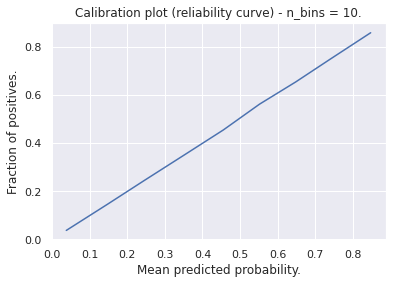

Validation:


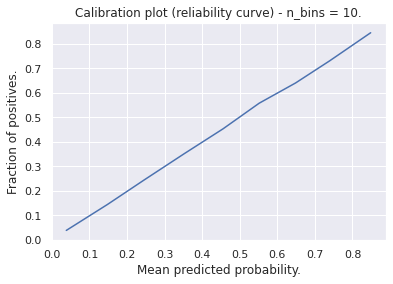

In [ ]:
# checking if probabilities are well calibrated or not
printb('Train:')
eval_set = 'train'
idx = dataset.loc[dataset.eval_set==eval_set,'eval_set'].index
n_bins=10
plot_calibration_curve(dataset.loc[dataset.eval_set==eval_set,'reordered'],
                        prob_pred[idx,1],
                        n_bins=n_bins,
                       normalize=False)
plt.show()

printb('Validation:')
eval_set = 'cv'
idx = dataset.loc[dataset.eval_set==eval_set,'eval_set'].index
n_bins=10
plot_calibration_curve(dataset.loc[dataset.eval_set==eval_set,'reordered'],
                        prob_pred[idx,1],
                        n_bins=n_bins,
                       normalize=False)
plt.show()

> Calibration curve is an almost straight line. Hence, the probabilities are well calibrated.

In [ ]:
# Finding best threshold
thresh_list = [0.18, 0.19, 0.20, 0.21, 0.22]
f_score_cv_list = []
best_f_score_cv = 0

tqdm_obj = tqdm(thresh_list)
for th in tqdm_obj:
    pred = (prob_pred[:,1]>=th).astype(np.uint8)
    target = 'dt_pred'
    dataset[target] = pred
    f_score_cv = f_score(dataset[dataset.eval_set=='cv'],
                        target=target,
                        pr_re=False)
    f_score_cv_list.append(f_score_cv)

    if(f_score_cv > best_f_score_cv):
        best_f_score_cv = f_score_cv
        best_thresh = th

    tqdm_obj.set_postfix({'Best Threshold':best_thresh,
                          'Best CV F1-score': best_f_score_cv})

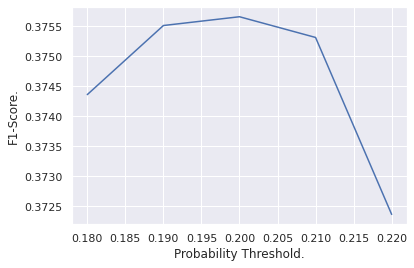

In [ ]:
plt.plot(thresh_list, f_score_cv_list)
plt.xlabel("Probability Threshold.")
plt.ylabel("F1-Score.");

> 0.20 is the best probability threshold.

In [ ]:
pred = (prob_pred[:,1]>=0.20).astype(np.uint8)
target = 'dt_pred'
dataset[target] = pred

In [ ]:
%%time
f_score_tr = f_score(dataset[dataset.eval_set=='train'],
                     target=target,
                     pr_re=False)
f_score_cv = f_score(dataset[dataset.eval_set=='cv'],
                     target=target,
                     pr_re=False)
print('Train F1-score     :',f_score_tr)
print('Validation F1-score:',f_score_cv)

Train F1-score     : 0.37837260199264927
Validation F1-score: 0.3756575239131667
CPU times: user 1min 46s, sys: 5.45 s, total: 1min 51s
Wall time: 1min 43s


In [ ]:
submission(dataset[dataset.eval_set=='test'],
           target=target,
           msg='Decision Tree. th: 0.2')

100% 4.30M/4.30M [00:01<00:00, 2.97MB/s]
Successfully submitted to Instacart Market Basket AnalysisWarning: Looks like you're using an outdated API Version, please consider updating (server 1.5.12 / client 1.5.4)
fileName                    date                 description                                     status    publicScore  privateScore  
--------------------------  -------------------  ----------------------------------------------  --------  -----------  ------------  
submission.csv              2021-07-16 15:14:26  Decision Tree. th: 0.2                          complete  0.37913      0.37745       
submission.csv              2021-07-01 19:01:01  1st-cut Approach Log-Reg th:0.18                complete  0.36886      0.36742       
last_order.csv              2021-07-01 16:47:38  reorders of last order as prediction            complete  0.32768      0.32763       
last_order.csv              2021-07-01 16:34:08  purchases of last order as reorder              complete  0.311

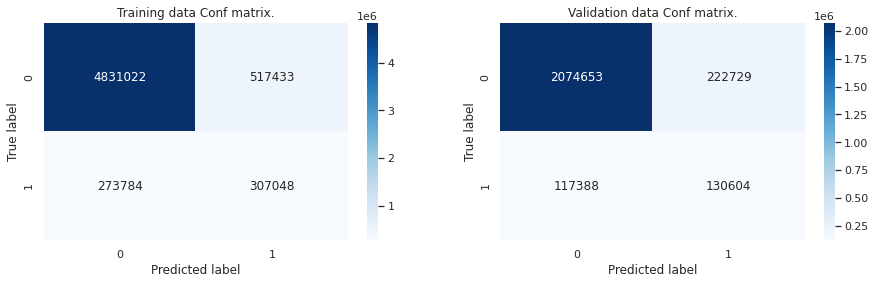

In [ ]:
# confusion matrix
fig,ax = plt.subplots(1,2,figsize=(15,4))
plot_confusion_matrix(dataset.loc[dataset.eval_set=='train','reordered'],
                 dataset.loc[dataset.eval_set=='train',target],
                 title='Training data Conf matrix.',
                 ax=ax[0])

plot_confusion_matrix(dataset.loc[dataset.eval_set=='cv','reordered'],
                 dataset.loc[dataset.eval_set=='cv',target],
                 title='Validation data Conf matrix.',
                 ax=ax[1])

In [ ]:
importance = calibrated_clf.calibrated_classifiers_[0].base_estimator.feature_importances_

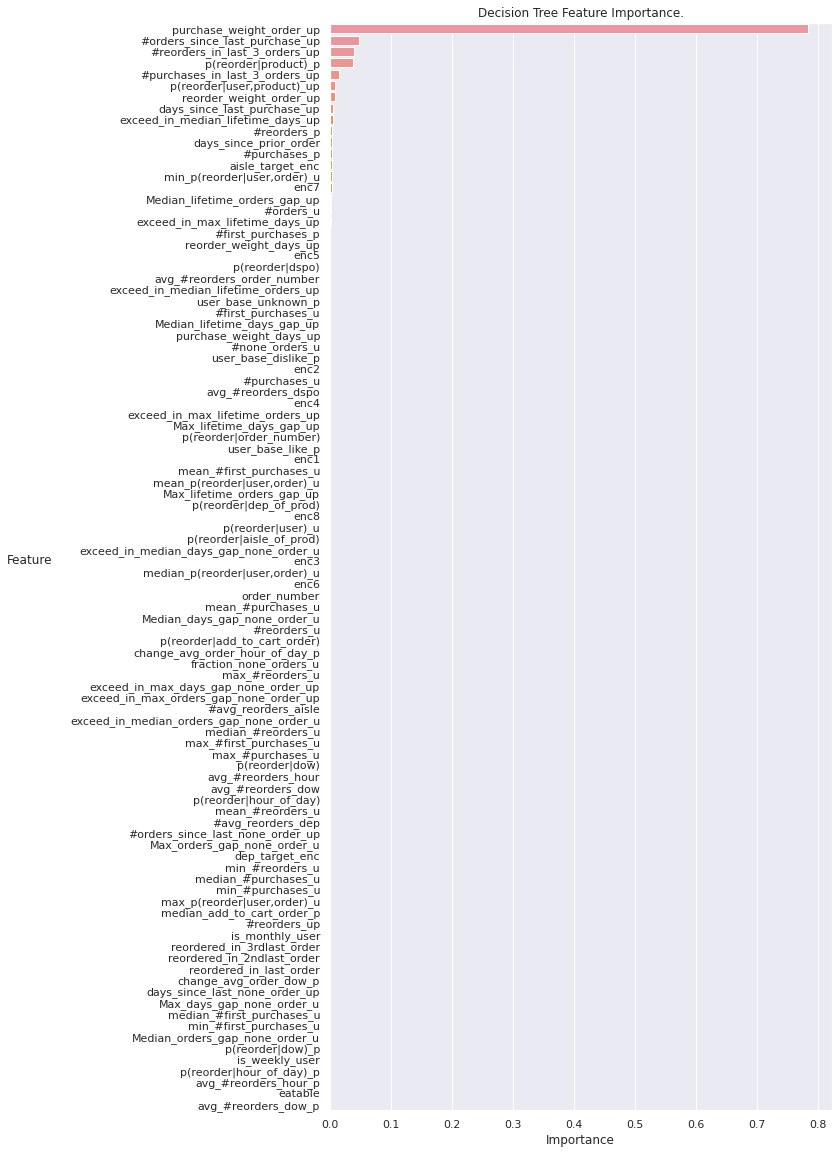

In [ ]:
ftr_imp = plot_feature_importance(importance,
                                  ftrs,
                                  'Decision Tree',
                                  figsize=(9,20),
                                  return_ftr_imp=True)

## Random Forest

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time
clf = RandomForestClassifier(class_weight='balanced_subsample',
                             n_estimators=150,
                             max_features="auto",
                             max_samples=2/3,
                             max_depth=None,
                             min_weight_fraction_leaf=0.00035,
                             random_state=9,
                             n_jobs=30)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)\
            .split(dataset.loc[dataset.eval_set=='train',ftrs],
                    dataset.loc[dataset.eval_set=='train','reordered'],
                    dataset.loc[dataset.eval_set=='train','order_id'])

calibrated_clf = CalibratedClassifierCV(base_estimator=clf,
                                        method='isotonic',
                                        cv=gss)

calibrated_clf.fit(dataset.loc[dataset.eval_set=='train',ftrs],
                   dataset.loc[dataset.eval_set=='train','reordered'])

CPU times: user 2h 14s, sys: 1min 3s, total: 2h 1min 18s
Wall time: 5min 6s


In [ ]:
%%time
prob_pred = batch_predict_proba(calibrated_clf,dataset[ftrs],batch_size=0.1)

CPU times: user 9min 40s, sys: 4.1 s, total: 9min 44s
Wall time: 41.1 s


Train:


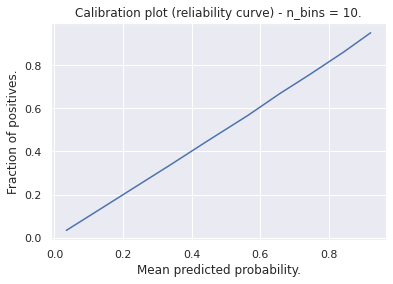

Validation:


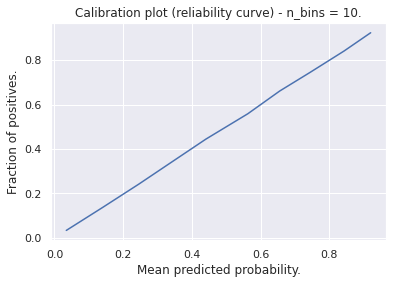

In [ ]:
# checking if probabilities are well calibrated or not
printb('Train:')
eval_set = 'train'
idx = dataset.loc[dataset.eval_set==eval_set,'eval_set'].index
n_bins=10
plot_calibration_curve(dataset.loc[dataset.eval_set==eval_set,'reordered'],
                        prob_pred[idx,1],
                        n_bins=n_bins,
                       normalize=False)
plt.show()

printb('Validation:')
eval_set = 'cv'
idx = dataset.loc[dataset.eval_set==eval_set,'eval_set'].index
n_bins=10
plot_calibration_curve(dataset.loc[dataset.eval_set==eval_set,'reordered'],
                        prob_pred[idx,1],
                        n_bins=n_bins,
                       normalize=False)
plt.show()

> Calibration curve is an almost straight line. Hence, the probabilities are well calibrated.

In [ ]:
# Finding best threshold
thresh_list = [0.18, 0.19, 0.20, 0.21, 0.22]
f_score_cv_list = []
best_f_score_cv = 0

tqdm_obj = tqdm(thresh_list)
for th in tqdm_obj:
    pred = (prob_pred[:,1]>=th).astype(np.uint8)
    target = 'rf_pred'
    dataset[target] = pred
    f_score_cv = f_score(dataset[dataset.eval_set=='cv'],
                        target=target,
                        pr_re=False)
    f_score_cv_list.append(f_score_cv)

    if(f_score_cv > best_f_score_cv):
        best_f_score_cv = f_score_cv
        best_thresh = th

    tqdm_obj.set_postfix({'Best Threshold':best_thresh,
                          'Best CV F1-score': best_f_score_cv})

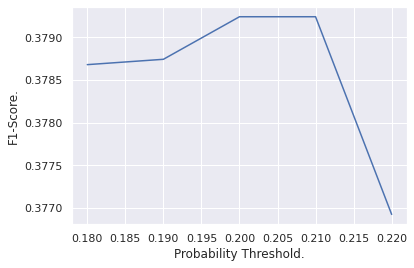

In [ ]:
plt.plot(thresh_list, f_score_cv_list)
plt.xlabel("Probability Threshold.")
plt.ylabel("F1-Score.");

> 0.20 is the best probability threshold.

In [ ]:
pred = (prob_pred[:,1]>=0.2).astype(np.uint8)
target = 'rf_pred'
dataset[target] = pred

In [ ]:
%%time
f_score_tr = f_score(dataset[dataset.eval_set=='train'],
                     target=target,
                     pr_re=False)
f_score_cv = f_score(dataset[dataset.eval_set=='cv'],
                     target=target,
                     pr_re=False)
print('Train F1-score     :',f_score_tr)
print('Validation F1-score:',f_score_cv)

Train F1-score     : 0.3829364175140252
Validation F1-score: 0.37923951424968283
CPU times: user 1min 49s, sys: 5.57 s, total: 1min 55s
Wall time: 1min 46s


In [ ]:
submission(dataset[dataset.eval_set=='test'],
           target=target,
           msg='Random Forest. th: 0.2')

100% 4.28M/4.28M [00:01<00:00, 3.16MB/s]
Successfully submitted to Instacart Market Basket AnalysisWarning: Looks like you're using an outdated API Version, please consider updating (server 1.5.12 / client 1.5.4)
fileName                    date                 description                                     status    publicScore  privateScore  
--------------------------  -------------------  ----------------------------------------------  --------  -----------  ------------  
submission.csv              2021-07-24 14:56:45  Random Forest. th: 0.2                          complete  0.38282      0.38121       
submission.csv              2021-07-16 15:14:26  Decision Tree. th: 0.2                          complete  0.37913      0.37745       
submission.csv              2021-07-01 19:01:01  1st-cut Approach Log-Reg th:0.18                complete  0.36886      0.36742       
last_order.csv              2021-07-01 16:47:38  reorders of last order as prediction            complete  0.327

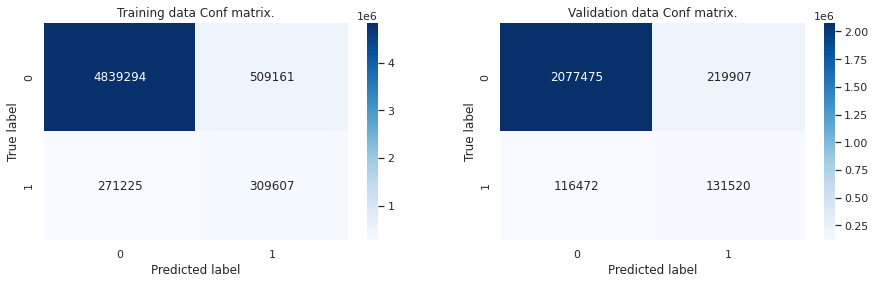

In [ ]:
# confusion matrix
fig,ax = plt.subplots(1,2,figsize=(15,4))
plot_confusion_matrix(dataset.loc[dataset.eval_set=='train','reordered'],
                 dataset.loc[dataset.eval_set=='train',target],
                 title='Training data Conf matrix.',
                 ax=ax[0])

plot_confusion_matrix(dataset.loc[dataset.eval_set=='cv','reordered'],
                 dataset.loc[dataset.eval_set=='cv',target],
                 title='Validation data Conf matrix.',
                 ax=ax[1])

In [ ]:
importance = calibrated_clf.calibrated_classifiers_[0].base_estimator.feature_importances_

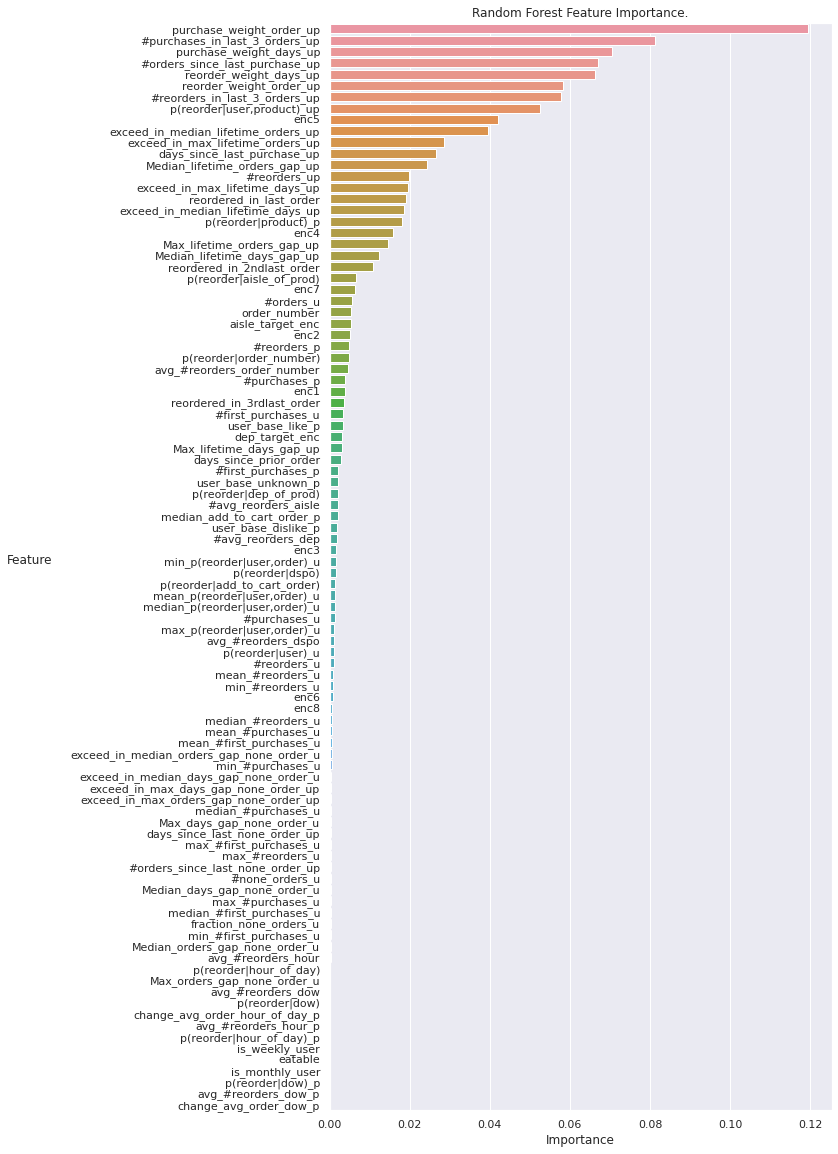

In [ ]:
ftr_imp = plot_feature_importance(importance,
                                  ftrs,
                                  'Random Forest',
                                  figsize=(9,20),
                                  return_ftr_imp=True)

## AdaBoost

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import GroupShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [ ]:
%%time
base_clf = DecisionTreeClassifier(max_depth=1)

clf = AdaBoostClassifier(base_estimator=base_clf,
                         n_estimators=50,
                         learning_rate=1,
                         random_state=9)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=5)\
            .split(dataset.loc[dataset.eval_set=='train',ftrs],
                    dataset.loc[dataset.eval_set=='train','reordered'],
                    dataset.loc[dataset.eval_set=='train','order_id'])

calibrated_clf = CalibratedClassifierCV(base_estimator=clf,
                                        method='isotonic',
                                        cv=gss)

calibrated_clf.fit(dataset.loc[dataset.eval_set=='train',ftrs],
                   dataset.loc[dataset.eval_set=='train','reordered'])

CPU times: user 47min 36s, sys: 4.3 s, total: 47min 40s
Wall time: 47min 28s


In [ ]:
%%time
prob_pred = batch_predict_proba(calibrated_clf,dataset[ftrs], batch_size=0.1)

CPU times: user 3min 59s, sys: 25.6 s, total: 4min 25s
Wall time: 4min 24s


Train:


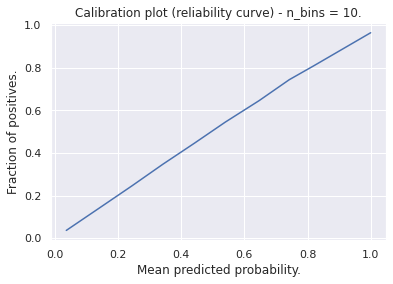

Validation:


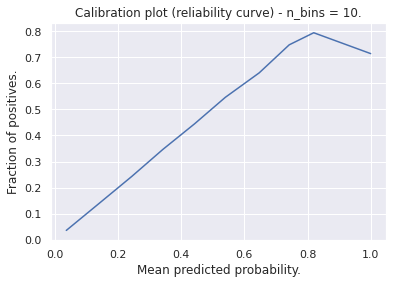

In [ ]:
# checking if probabilities are well calibrated or not
printb('Train:')
eval_set = 'train'
idx = dataset.loc[dataset.eval_set==eval_set,'eval_set'].index
n_bins=10
plot_calibration_curve(dataset.loc[dataset.eval_set==eval_set,'reordered'],
                        prob_pred[idx,1],
                        n_bins=n_bins,
                       normalize=False)
plt.show()

printb('Validation:')
eval_set = 'cv'
idx = dataset.loc[dataset.eval_set==eval_set,'eval_set'].index
n_bins=10
plot_calibration_curve(dataset.loc[dataset.eval_set==eval_set,'reordered'],
                        prob_pred[idx,1],
                        n_bins=n_bins,
                       normalize=False)
plt.show()

> Calibration curve is little bit deviated from a 45 deg straight line. But still it is good. Hence, the probabilities are calibrated.

In [ ]:
# Finding best threshold
thresh_list = [0.18, 0.19, 0.20, 0.21, 0.22]
f_score_cv_list = []
best_f_score_cv = 0

tqdm_obj = tqdm(thresh_list)
for th in tqdm_obj:
    pred = (prob_pred[:,1]>=th).astype(np.uint8)
    target = 'adb_pred'
    dataset[target] = pred
    f_score_cv = f_score(dataset[dataset.eval_set=='cv'],
                        target=target,
                        pr_re=False)
    f_score_cv_list.append(f_score_cv)

    if(f_score_cv > best_f_score_cv):
        best_f_score_cv = f_score_cv
        best_thresh = th

    tqdm_obj.set_postfix({'Best Threshold':best_thresh,
                          'Best CV F1-score': best_f_score_cv})

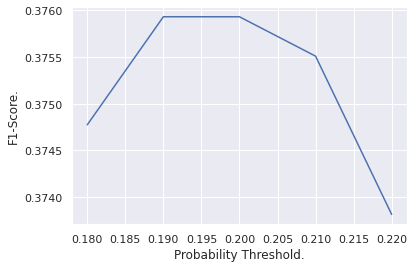

In [ ]:
plt.plot(thresh_list, f_score_cv_list)
plt.xlabel("Probability Threshold.")
plt.ylabel("F1-Score.");

> 0.19 is the best probability threshold.

In [ ]:
pred = (prob_pred[:,1]>=0.19).astype(np.uint8)
target = 'adb_pred'
dataset[target] = pred

In [ ]:
%%time
f_score_tr = f_score(dataset[dataset.eval_set=='train'],
                     target=target,
                     pr_re=False)
f_score_cv = f_score(dataset[dataset.eval_set=='cv'],
                     target=target,
                     pr_re=False)
print('Train F1-score     :',f_score_tr)
print('Validation F1-score:',f_score_cv)

Train F1-score     : 0.3760896135372489
Validation F1-score: 0.3759309379700223
CPU times: user 1min 51s, sys: 4.98 s, total: 1min 56s
Wall time: 1min 48s


In [ ]:
submission(dataset[dataset.eval_set=='test'],
           target=target,
           msg='AdaBoost th: 0.19')

100% 4.43M/4.43M [00:00<00:00, 4.81MB/s]
Successfully submitted to Instacart Market Basket AnalysisWarning: Looks like you're using an outdated API Version, please consider updating (server 1.5.12 / client 1.5.4)
fileName                    date                 description                                     status    publicScore  privateScore  
--------------------------  -------------------  ----------------------------------------------  --------  -----------  ------------  
submission.csv              2021-07-24 14:59:54  AdaBoost th: 0.19                               complete  0.37906      0.37711       
submission.csv              2021-07-24 14:56:45  Random Forest. th: 0.2                          complete  0.38282      0.38121       
submission.csv              2021-07-16 15:14:26  Decision Tree. th: 0.2                          complete  0.37913      0.37745       
submission.csv              2021-07-01 19:01:01  1st-cut Approach Log-Reg th:0.18                complete  0.368

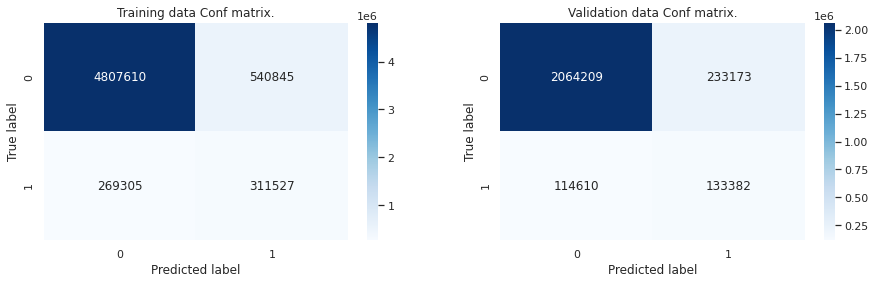

In [ ]:
# confusion matrix
fig,ax = plt.subplots(1,2,figsize=(15,4))
plot_confusion_matrix(dataset.loc[dataset.eval_set=='train','reordered'],
                 dataset.loc[dataset.eval_set=='train',target],
                 title='Training data Conf matrix.',
                 ax=ax[0])

plot_confusion_matrix(dataset.loc[dataset.eval_set=='cv','reordered'],
                 dataset.loc[dataset.eval_set=='cv',target],
                 title='Validation data Conf matrix.',
                 ax=ax[1])

In [ ]:
importance = calibrated_clf.calibrated_classifiers_[0].base_estimator.feature_importances_

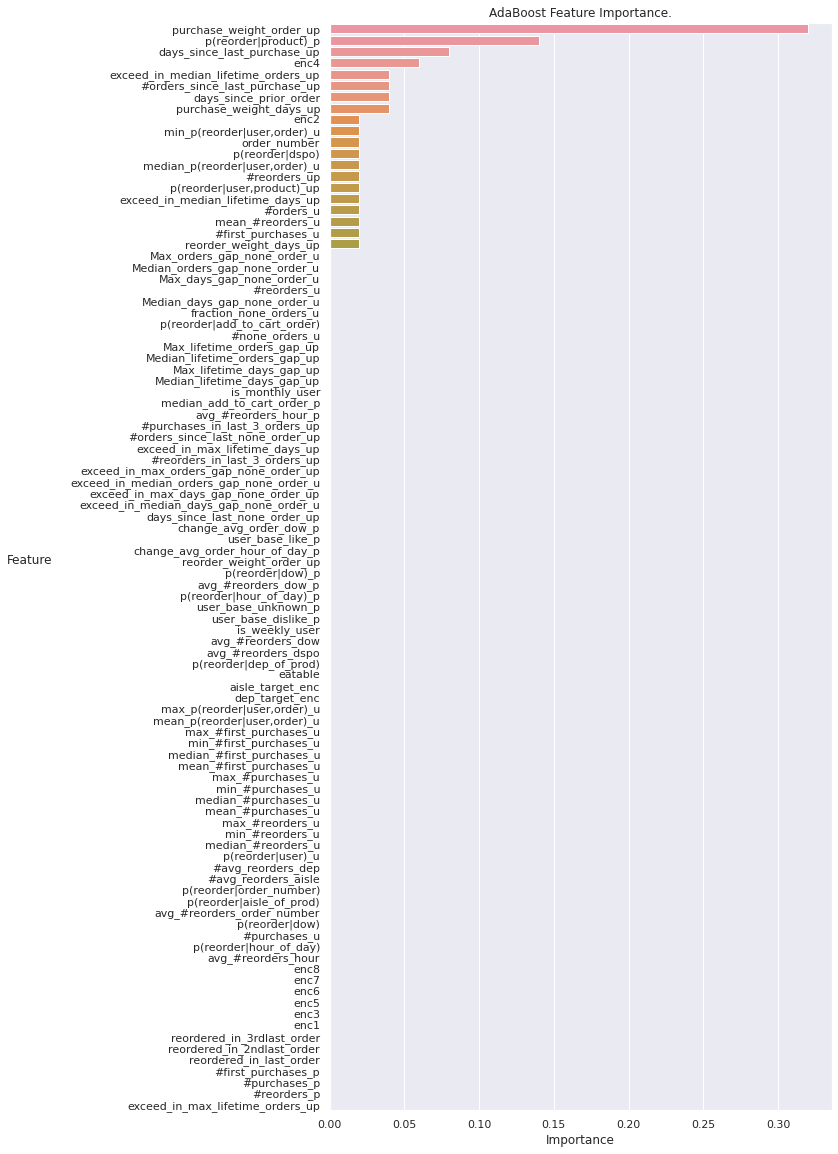

In [ ]:
ftr_imp = plot_feature_importance(importance,
                                  ftrs,
                                  'AdaBoost',
                                  figsize=(9,20),
                                  return_ftr_imp=True)

## LGBM Model:

In [ ]:
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import GroupShuffleSplit

In [ ]:
%%time
clf = LGBMClassifier(boosting_type='gbdt',
                     objective='binary',
                     n_estimators=200,
                     is_unbalance=True,
                     learning_rate=0.025,
                     lambda_l1=200,
                     lambda_l2=0,
                     max_depth=10,
                     num_leaves=96,
                     pos_subsample=0.95,    # subsampling +ve datapoints.
                     neg_subsample=0.95,    # subsampling -ve datapoints.
                     bagging_freq=5,    # subsampling after every k iteration
                     feature_fraction=0.5,  # fraction of ftrs for each tree
                     feature_fraction_bynode=0.8, # frac of ftrs for each node of tree
                     min_child_weight=4500,
                     importance_type='gain',
                     random_state=3,
                     n_jobs=-1)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)\
            .split(dataset.loc[dataset.eval_set=='train',ftrs],
                    dataset.loc[dataset.eval_set=='train','reordered'],
                    dataset.loc[dataset.eval_set=='train','order_id'])

calibrated_clf = CalibratedClassifierCV(base_estimator=clf,
                                        method='isotonic',
                                        cv=gss)

calibrated_clf.fit(dataset.loc[dataset.eval_set=='train',ftrs],
                   dataset.loc[dataset.eval_set=='train','reordered'])

CPU times: user 33min 6s, sys: 2.96 s, total: 33min 9s
Wall time: 1min 8s


In [ ]:
%%time
prob_pred = batch_predict_proba(calibrated_clf,dataset[ftrs],batch_size=0.1)

CPU times: user 6min 54s, sys: 1.7 s, total: 6min 56s
Wall time: 30.1 s


Train:


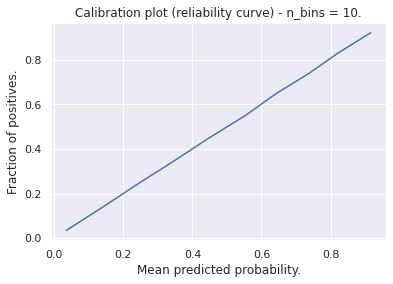

Validation:


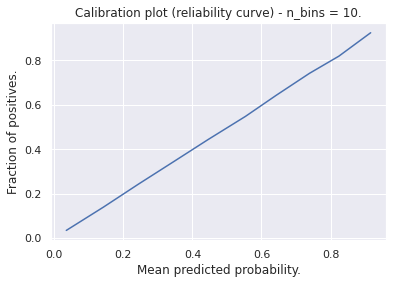

In [ ]:
# checking if probabilities are well calibrated or not
printb('Train:')
eval_set = 'train'
idx = dataset.loc[dataset.eval_set==eval_set,'eval_set'].index
n_bins=10
plot_calibration_curve(dataset.loc[dataset.eval_set==eval_set,'reordered'],
                        prob_pred[idx,1],
                        n_bins=n_bins,
                       normalize=False)
plt.show()

printb('Validation:')
eval_set = 'cv'
idx = dataset.loc[dataset.eval_set==eval_set,'eval_set'].index
n_bins=10
plot_calibration_curve(dataset.loc[dataset.eval_set==eval_set,'reordered'],
                        prob_pred[idx,1],
                        n_bins=n_bins,
                       normalize=False)
plt.show()

> Calibration curve is an almost straight line. Hence, the probabilities are well calibrated.

In [ ]:
# Finding best threshold
thresh_list = [0.18, 0.19, 0.20, 0.21, 0.22]
f_score_cv_list = []
best_f_score_cv = 0

tqdm_obj = tqdm(thresh_list)
for th in tqdm_obj:
    pred = (prob_pred[:,1]>=th).astype(np.uint8)
    target = 'lgbm_pred'
    dataset[target] = pred
    f_score_cv = f_score(dataset[dataset.eval_set=='cv'],
                        target=target,
                        pr_re=False)
    f_score_cv_list.append(f_score_cv)

    if(f_score_cv > best_f_score_cv):
        best_f_score_cv = f_score_cv
        best_thresh = th

    tqdm_obj.set_postfix({'Best Threshold':best_thresh,
                          'Best CV F1-score': best_f_score_cv})

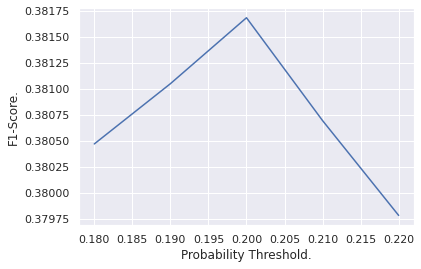

In [ ]:
plt.plot(thresh_list, f_score_cv_list)
plt.xlabel("Probability Threshold.")
plt.ylabel("F1-Score.");

> 0.20 is the best probability threshold.

In [ ]:
pred = (prob_pred[:,1]>=0.2).astype(np.uint8)
target = 'lgbm_pred'
dataset[target] = pred

In [ ]:
%%time
f_score_tr = f_score(dataset[dataset.eval_set=='train'],
                     target=target,
                     pr_re=False)
f_score_cv = f_score(dataset[dataset.eval_set=='cv'],
                     target=target,
                     pr_re=False)
print('Train F1-score     :',f_score_tr)
print('Validation F1-score:',f_score_cv)

Train F1-score     : 0.3833972001591395
Validation F1-score: 0.3816832156221942
CPU times: user 1min 50s, sys: 5.76 s, total: 1min 56s
Wall time: 1min 47s


In [ ]:
submission(dataset[dataset.eval_set=='test'],
           target=target,
           msg='LightGBM th:0.2')

100% 4.31M/4.31M [00:01<00:00, 3.08MB/s]
Successfully submitted to Instacart Market Basket AnalysisWarning: Looks like you're using an outdated API Version, please consider updating (server 1.5.12 / client 1.5.4)
fileName                    date                 description                                     status    publicScore  privateScore  
--------------------------  -------------------  ----------------------------------------------  --------  -----------  ------------  
submission.csv              2021-07-24 15:13:11  LightGBM th:0.2                                 complete  0.38470      0.38380       
submission.csv              2021-07-24 14:59:54  AdaBoost th: 0.19                               complete  0.37906      0.37711       
submission.csv              2021-07-24 14:56:45  Random Forest. th: 0.2                          complete  0.38282      0.38121       
submission.csv              2021-07-16 15:14:26  Decision Tree. th: 0.2                          complete  0.379

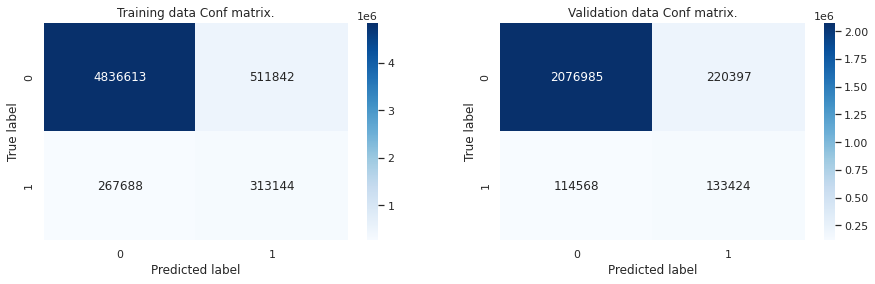

In [ ]:
# confusion matrix
fig,ax = plt.subplots(1,2,figsize=(15,4))
plot_confusion_matrix(dataset.loc[dataset.eval_set=='train','reordered'],
                 dataset.loc[dataset.eval_set=='train',target],
                 title='Training data Conf matrix.',
                 ax=ax[0])

plot_confusion_matrix(dataset.loc[dataset.eval_set=='cv','reordered'],
                 dataset.loc[dataset.eval_set=='cv',target],
                 title='Validation data Conf matrix.',
                 ax=ax[1])

In [ ]:
importance = calibrated_clf.calibrated_classifiers_[0].base_estimator.feature_importances_

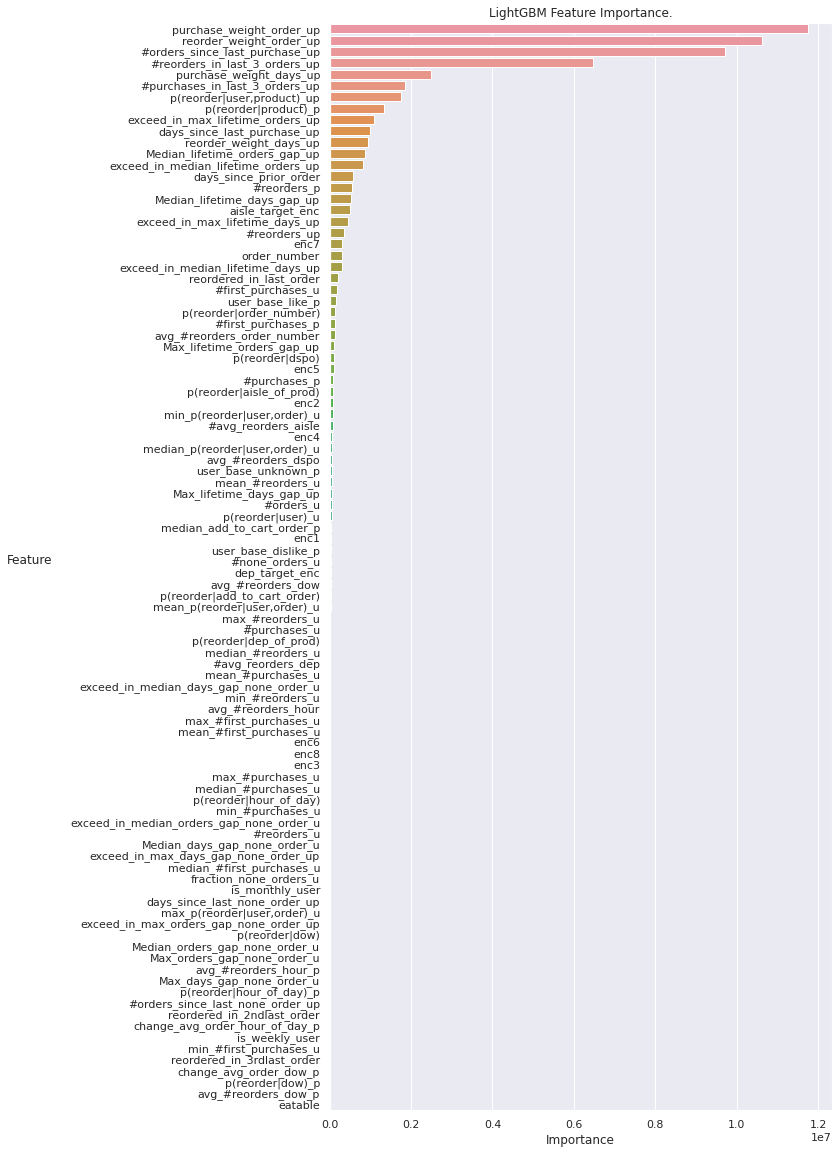

In [ ]:
ftr_imp = plot_feature_importance(importance,
                                  ftrs,
                                  'LightGBM',
                                  figsize=(9,20),
                                  return_ftr_imp=True)

In [ ]:
dataset.to_feather('dataset.feather')

In [ ]:
kaggle_file_uploader(['./dataset.feather'],
                     msg='Full Dataset with predictions.')

Data package template written to: data/dataset-metadata.json
Starting upload for file dataset.feather
100% 2.03G/2.03G [00:30<00:00, 70.4MB/s]
Upload successful: dataset.feather (2GB)
Dataset version is being created. Please check progress at /api/v1/datasets/status/shubhamscifi/instacart


In [ ]:
print("Zero Importance Features:")
ftr_imp[ftr_imp.Importance==0]

Zero Importance Features:


,Feature,Importance
92,change_avg_order_dow_p,0.0
93,p(reorder|dow)_p,0.0
94,avg_#reorders_dow_p,0.0
95,eatable,0.0


In [ ]:
dataset = pd.read_feather('dataset.feather')

In [ ]:
# Excluding the zero importance features.
ftrs = (list(dataset.columns[5:27]) +  
        list(dataset.columns[28:49]) + 
        list(dataset.columns[50:81]) + 
        list(dataset.columns[83:88]) + 
        list(dataset.columns[89:102]))
print("No. of features in data:",len(ftrs))

No. of features in data: 92


## Summary of Predictive models:
Model | Test F1-score | Rank
--- | --- | ---
**LightGBM** | **0.38380** | **1st**
Random Forest | 0.38121 | 2nd
Decision Tree | 0.37745 | 3rd
AdaBoost | 0.37711 | 4th
Logistic-Reg (only on 44 ftrs) | 0.36742 | 5th



**Best Model:**
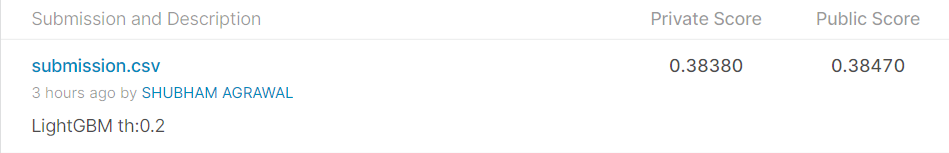


---
---